In [33]:
import os
import glob
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from PIL import Image
from sklearn.preprocessing import RobustScaler #importando o Robust Scaler
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
import scipy

In [2]:
load_dotenv('test.env')
raw_dir = os.environ['RAW_DIR']
interim_dir = os.environ['INTERIM_DIR']

In [3]:
raw_dir, interim_dir

('/mnt/data/Personal/Dados/IA368X/P4/data/raw/',
 '/mnt/data/Personal/Dados/IA368X/P4/data/interim/')

In [4]:
def medianmad_norm(arr_like):
    '''
    Normalize by median and MAD

    Modified version from the function made available by the professor
    '''
    np_arr = np.array(arr_like)
    median = np.median(np_arr)
    dev = np.abs(np_arr - median)
    mad = np.median(dev)
    norm = ((np_arr - median) / mad)
    return (norm,mad)

def tanh_modified_norm(arr_like):
    np_arr = np.array(arr_like)

    mean = np.mean(np_arr)
    std = np.std(np_arr)

    return 0.5*(np.tanh(0.01*((np_arr-mean)/std))+1)

In [5]:
with open("../data/interim/filenames.txt") as f:
    filenames = f.readlines()

img_list = [os.path.join(raw_dir, img_path[:-1]) for img_path in filenames]

In [6]:
def get_mask_path(img_path, mask_suffix='_mask.png'):
    img_wo_ext = os.path.splitext(img_path)[0]
    mask_path = img_wo_ext + mask_suffix
    return mask_path

In [7]:
def save_histogram(arr_like, output_path, title='', nbins=20):
    h, bin_edges = np.histogram(arr_like, nbins)
    w = np.max(arr_like)/nbins
    bin_centers = bin_edges[1:]-(w/2)
    plt.figure(dpi=100, frameon=False)
    if len(title) > 0:
        plt.title(title)
    plt.bar(bin_centers, h, width=w)
    plt.savefig(output_path)
    plt.close()

In [8]:
def crop_zero_borders(img_arr):
    coords = np.argwhere(img_arr > 0)

    y_min, x_min = np.min(coords, axis=0)
    y_max, x_max = np.max(coords, axis=0) + 1

    return img_arr[y_min:y_max, x_min:x_max], (y_min, y_max, x_min, x_max)

In [38]:
def get_lbp_histogram(img, radius=3, method='uniform', bins = 30):
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, method)
    hist, bins = np.histogram(lbp, bins=bins)
    return lbp, hist, bins

def get_histogram_attributes(hist):
    return {
        # 'Min': np.min(hist),
        'Max': np.max(hist),
        'Mean': np.mean(hist),
        'Variation': scipy.stats.variation(hist),
        # 'Mode' : scipy.stats.mode(hist)[0][0],
        'Median': np.median(hist),
        'Skewness': scipy.stats.skew(hist),
        'Kurtosis': scipy.stats.kurtosis(hist),
        'Entropy': scipy.stats.entropy(hist),
    }

In [66]:
texture_list = []
for img_path in img_list:
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        continue

    mask_path = get_mask_path(img_path)
    if not os.path.exists(mask_path):
        continue

    mask = cv.imread(mask_path, cv.IMREAD_UNCHANGED)
    if mask is None:
        continue

    cropped, (y_min, y_max, x_min, x_max) = crop_zero_borders(img)

    normed = tanh_modified_norm(cropped)

    masked = cropped * (mask == mask.max())[y_min:y_max, x_min:x_max]

    # masked_normed = normed * (mask == mask.max())[y_min:y_max, x_min:x_max]

    distances = [5]
    angles = np.arange(0,200,20)
    glcm = graycomatrix(masked, distances=distances, angles=angles, levels=256, symmetric=False, normed=False)
    a = graycoprops(glcm, prop='contrast').flatten()
    max_angle_idx = np.argmax(a)
    max_contrast = a[max_angle_idx]
    max_angle = angles[max_angle_idx]

    lbp, lbp_hist, lbp_bins = get_lbp_histogram(masked)
    lbp_attr = get_histogram_attributes(lbp_hist)

    label = img_path.split('/')[-2]

    # print('mask', masked.max(), masked.min(), 'contrast', max_contrast, max_dist, max_angle, "hist", lbp_attr)

    lbp_attr.update({
        'ContrastMax': max_contrast,
        'ContrastAngle': max_angle,
        'Label': label,
    })

    texture_list.append(lbp_attr)

    # out_path = os.path.join(interim_dir, img_path.split(raw_dir)[1])
    # out_path = os.path.join(interim_dir, "hists", os.path.splitext(img_path.split(raw_dir)[1])[0] + ".png")
    
    # ok = cv.imwrite(out_path, masked)
    # print("write", img_path, out_path, ok)

    # os.makedirs(os.path.dirname(out_path), exist_ok=True)
    # save_histogram(masked[masked > 0], out_path, "Modified norm lesion histogram", nbins=50)

df = pd.DataFrame(texture_list)

In [68]:
df

,Max,Mean,Variation,Median,Skewness,Kurtosis,Entropy,ContrastMax,ContrastAngle,Label
0,170222,5688.000000,5.371519,8.5,5.199467,25.034466,0.023733,120.920740,100,AVC
1,146657,5580.600000,4.700349,444.0,5.178751,24.891604,0.698327,926.851391,60,AVC
2,166013,5609.000000,5.310488,62.5,5.199328,25.033538,0.106714,334.918481,60,AVC
3,165884,5557.200000,5.357367,23.5,5.199459,25.034416,0.045443,126.645963,20,AVC
4,174742,5835.900000,5.374506,4.5,5.199467,25.034465,0.018741,66.948450,20,AVC
...,...,...,...,...,...,...,...,...,...,...
557,169065,5653.466667,5.367462,9.5,5.199466,25.034459,0.030427,183.834941,60,EM
558,166130,5564.000000,5.358803,13.0,5.199458,25.034406,0.042678,273.953100,60,EM
559,161196,5434.000000,5.322857,33.5,5.199397,25.033996,0.090897,747.324748,160,EM
560,148146,4992.000000,5.325141,24.0,5.199424,25.034181,0.089379,600.135809,160,EM


In [64]:
df['ContrastAngle'].mode()

0    60
Name: ContrastAngle, dtype: int64

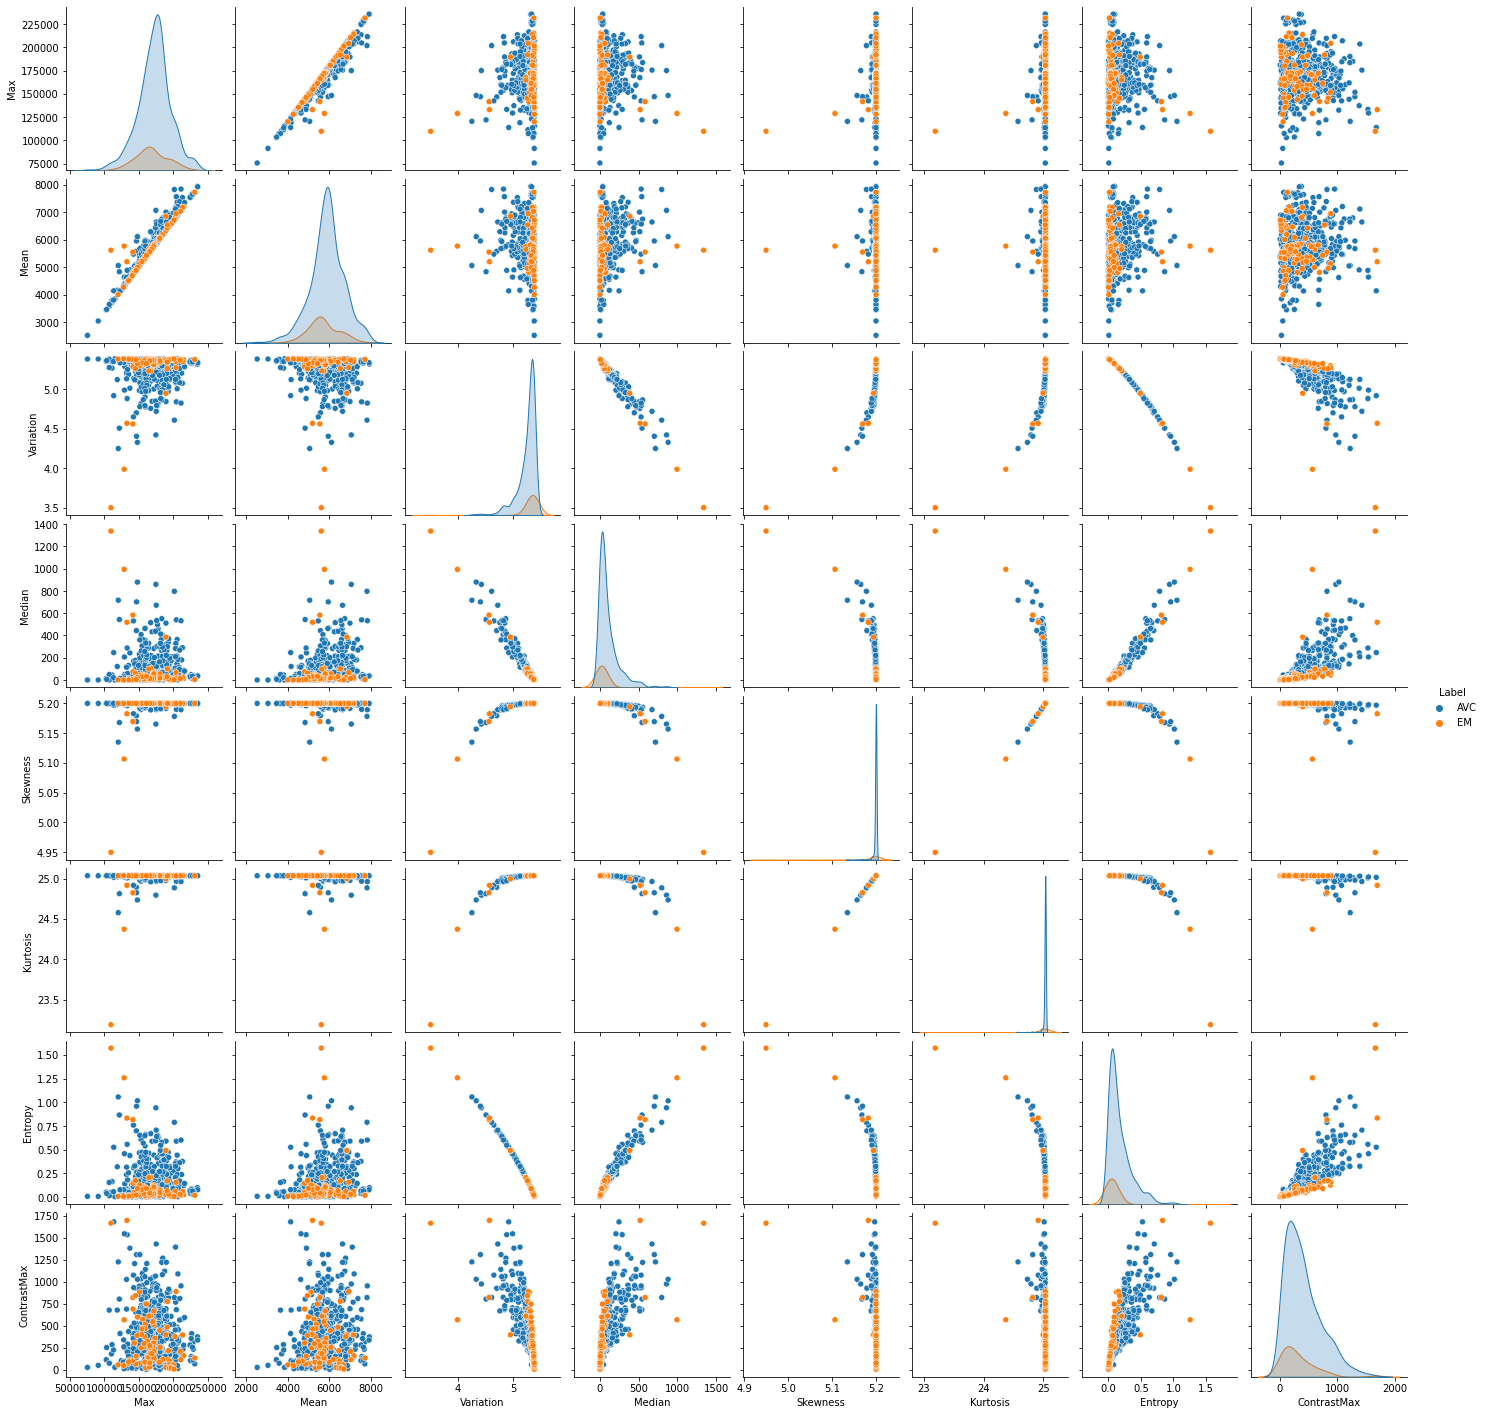

In [69]:
sns.pairplot(df, vars=['Max','Mean','Variation','Median','Skewness','Kurtosis','Entropy','ContrastMax'], hue='Label')

<BarContainer object of 20 artists>

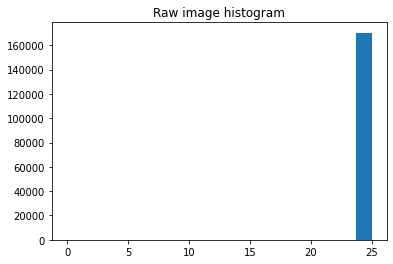

In [32]:
nbins=20
h, bin_edges = np.histogram(lbp, nbins)
w=lbp.max()/nbins
bin_centers = bin_edges[1:]-(w/2)
plt.title("Raw image histogram")
plt.bar(bin_centers, h, width=w)
# sns.distplot(lbp)


In [50]:
s = pd.Series({
    'a':0,
    'b':1,
    'c':2,
})
d = pd.DataFrame(columns=['a','b','c'])
pd.concat([d,s], axis=0)

,a,b,c,0
a,NaN,NaN,NaN,0.0
b,NaN,NaN,NaN,1.0
c,NaN,NaN,NaN,2.0


In [ ]:
coords = np.argwhere(img > 0)

y_min, x_min = np.min(coords, axis=0)
y_max, x_max = np.max(coords, axis=0) + 1

coords, img[y_min, x_min], img[y_max, x_max]


(array([[ 27, 184],
        [ 27, 185],
        [ 27, 186],
        ...,
        [434, 206],
        [440, 211],
        [440, 212]]),
 0,
 0)

In [ ]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
img[6,361]

0

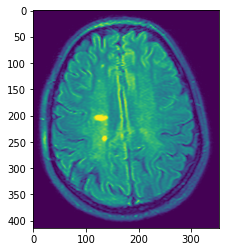

In [ ]:
plt.imshow(cropped)

In [ ]:
img.shape, cropped.shape

((448, 448), (414, 354))

In [ ]:
with Image.open(os.path.join(raw_dir, 'AVC/051_FLAIR12_mask.png')) as f:
    test_mask = np.array(f)

test_mask.shape, test_mask.max(), test_mask.min(), test_mask.dtype

((512, 512), 254, 253, dtype('int32'))

In [ ]:
test_mask = cv.imread(os.path.join(raw_dir, 'AVC/051_FLAIR12_mask.png'), cv.IMREAD_UNCHANGED)
test_mask = test_mask == test_mask.max()
test_mask.shape, test_mask.max(), test_mask.min(), test_mask.dtype

((512, 512), True, False, dtype('bool'))

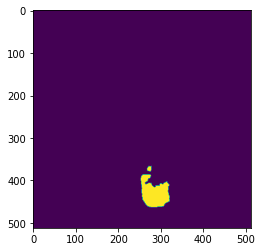

In [ ]:
plt.imshow(test_mask)